## trastuzumap responder/nonresponder 구분하기

In [83]:

import os
import h5py
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args
from PIL import ImageOps

import matplotlib.pyplot as plt
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset

train_dir =r"C:\Users\roobe\PKG - HER2 tumor ROIs_v3\Yale_trastuzumab_response_cohort\patches\train"
val_dir = r"C:\Users\roobe\PKG - HER2 tumor ROIs_v3\Yale_trastuzumab_response_cohort\patches\test"

class HistogramEqualization:
    def __call__(self, img):
        return ImageOps.equalize(img)  # 이미지 대비를 자동으로 맞춤

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),       # 크기 조정
    transforms.ToTensor(),               # 이미지 -> 텐서
    transforms.Normalize([0.5]*3, [0.5]*3)  # 정규화
])
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomApply([
        HistogramEqualization(),
       # train_transform 내 distortion 줄이기
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.05),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05))
# Perspective 제거, 너무 강력함

    ]),  # 전체 중 90% 확률로 랜덤 조합 적용
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# ImageFolder로 원본 및 증강 데이터셋 생성
base_dataset = datasets.ImageFolder(root=train_dir, transform=base_transform)
aug_dataset = datasets.ImageFolder(root=train_dir, transform=aug_transform)

# 데이터셋 세개 이어붙ㅇ기 ->6배
train_dataset = ConcatDataset([base_dataset] + [aug_dataset]*5)  # aug 5회 반복


# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# 검증 데이터셋은 증강 없이
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# 클래스 확인
print("클래스 목록:", base_dataset.classes)


클래스 목록: ['nonresponder', 'responder']


In [84]:
import os
import shutil
#  train/val 폴더의 경론데 이름 설정이 좀 이상해요
train_dir =r"C:\Users\roobe\PKG - HER2 tumor ROIs_v3\Yale_trastuzumab_response_cohort\patches\train"
val_dir = r"C:\Users\roobe\PKG - HER2 tumor ROIs_v3\Yale_trastuzumab_response_cohort\patches\test"
# 각 폴더 내부의 .ipynb_checkpoints 폴더 삭제
for base_folder in [train_dir, val_dir]:
    for root, dirs, files in os.walk(base_folder):
        for d in dirs:
            if d == ".ipynb_checkpoints":
                full_path = os.path.join(root, d)
                print("삭제 중:", full_path)
                shutil.rmtree(full_path)

print(".ipynb_checkpoints 폴더 전부 삭제 완료!")

 #애는 폴더만 삭제했는데 .ipynb_checkpoints 이걸 클래스로 인식해서 오류났대요

.ipynb_checkpoints 폴더 전부 삭제 완료!


In [85]:
train =r"C:\Users\roobe\PKG - HER2 tumor ROIs_v3\Yale_trastuzumab_response_cohort\patches\train\nonresponder"
exts = ('.png', '.jpg', '.jpeg')  # 이미지 확장자

count = len([f for f in os.listdir(train) if f.lower().endswith(exts)])
print(f"클래스 'nonresponder' 폴더의 이미지 수: {count}")

클래스 'nonresponder' 폴더의 이미지 수: 9876


In [86]:
train=r"C:\Users\roobe\PKG - HER2 tumor ROIs_v3\Yale_trastuzumab_response_cohort\patches\train\responder"
exts = ('.png', '.jpg', '.jpeg')  # 이미지 확장자

count = len([f for f in os.listdir(train) if f.lower().endswith(exts)])
print(f"클래스 'responder' 폴더의 이미지 수: {count}")

클래스 'responder' 폴더의 이미지 수: 5886


In [87]:
print(f"전체 데이터 개수: {len(train_dataset)}")

전체 데이터 개수: 94572


In [88]:
from collections import Counter

labels = [label for _, label in base_dataset.samples]  # ImageFolder는 (path, label)로 구성됨
class_counts = Counter(labels)
print("클래스별 샘플 수:", class_counts)


클래스별 샘플 수: Counter({0: 9876, 1: 5886})


In [97]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # L1 ImgIn shape=(15161, 224, 224, 3)
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 ImgIn shape=(?, 32, 56, 56)
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2))
        
        self.dropout = nn.Dropout2d(p=0.5)  # Dropout 레이어 추가
        self.fc = nn.Linear(64*14*14, 4)
        nn.init.kaiming_normal_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 여기랑 fc레이어랑 안맞는데요
        out = self.fc(out)
        return out

In [98]:
learning_rate = 0.0001
epochs = 20

# 클래스 불균형 가중치 설정 (예: 2번째 클래스에 더 높은 가중치)
weights_tensor = torch.tensor([1/9876, 1/5886], dtype=torch.float).to(device)

# 손실함수 정의 (가중치 적용)
criterion = nn.CrossEntropyLoss(weight=weights_tensor) #변경된 가중치를 불러옴

# 옵티마이저 정의 (예: Adam)
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)


In [99]:
base_dataset.class_to_idx



{'nonresponder': 0, 'responder': 1}

In [100]:
train_batch = len(train_loader)
val_batch = len(val_loader)

In [101]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

print('Learning started.')

# 스케줄러 정의 (성능 기반 자동 감소)-> 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, verbose=True)

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

best_val_loss = 10**9
patience_limit = 10
patience_check = 0

for epoch in range(epochs):
    train_loss = 0
    correct = 0

    model.train()
    for X, Y in train_loader:
        X = X.to(device)
        Y = Y.to(device)

        optimizer.zero_grad()
        Y_pred = model(X)
        loss = criterion(Y_pred, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss / train_batch
        correct += (torch.argmax(Y_pred, 1) == Y).sum()

    train_acc = (100 * correct / len(train_loader.dataset))
    train_acc_list.append(train_acc.item())
    train_loss_list.append(train_loss.item())

    # validation
    model.eval()
    with torch.no_grad():   
        val_loss = 0
        correct = 0

        for X, Y in val_loader:
            X = X.to(device)
            Y = Y.to(device)

            Y_pred = model(X)
            loss = criterion(Y_pred, Y)
            val_loss += loss / val_batch
            correct += (torch.argmax(Y_pred, 1) == Y).sum()

        val_acc = (100 * correct / len(val_loader.dataset))
        val_acc_list.append(val_acc.item())
        val_loss_list.append(val_loss.item())

    # 스케줄러 적용 (val loss 기준)
    scheduler.step(val_loss.item())

    print("[Epoch %2d] loss %.4f  acc %.2f, val loss %.4f  val acc %.2f"
          % (epoch + 1, train_loss, train_acc, val_loss, val_acc))

    # Early stopping
    if val_loss. item() > best_val_loss:
        patience_check += 1
        if patience_check >= patience_limit:
            print('Early Stopping!')
            break
    else:
        best_val_loss = val_loss.item()
        patience_check = 0 

print('Learning Finished!')  
torch.save(model.state_dict(), 'resnet1.pth') #이번에도 안되면 넘어갈께뇨->이제 진짜 끝끝 더는 안해볼꺼임

Learning started.
[Epoch  1] loss 0.1654  acc 93.45, val loss 1.3610  val acc 62.54
[Epoch  2] loss 0.1303  acc 94.98, val loss 1.8272  val acc 59.61
[Epoch  3] loss 0.1130  acc 95.76, val loss 2.7087  val acc 50.78
[Epoch  4] loss 0.0952  acc 96.41, val loss 2.0422  val acc 57.67
[Epoch  5] loss 0.0868  acc 96.82, val loss 1.6770  val acc 65.10
[Epoch  6] loss 0.0768  acc 97.17, val loss 2.6070  val acc 51.79
Epoch 00007: reducing learning rate of group 0 to 8.0000e-05.
[Epoch  7] loss 0.0730  acc 97.33, val loss 1.8733  val acc 60.51
[Epoch  8] loss 0.0534  acc 98.08, val loss 2.3012  val acc 61.91
[Epoch  9] loss 0.0483  acc 98.27, val loss 2.8186  val acc 57.94
[Epoch 10] loss 0.0468  acc 98.35, val loss 3.0454  val acc 61.25
[Epoch 11] loss 0.0441  acc 98.43, val loss 2.2136  val acc 64.96
Early Stopping!
Learning Finished!


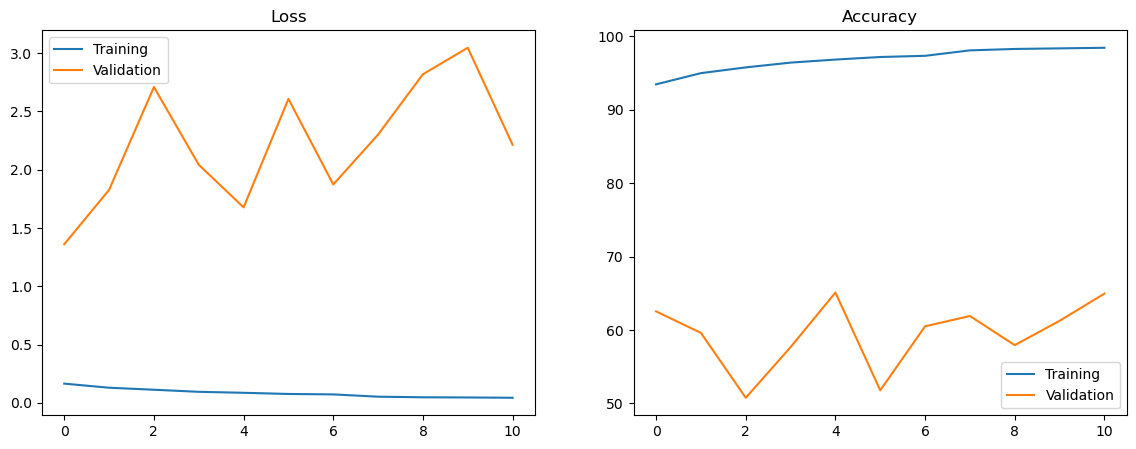

In [102]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.plot(range(len(train_loss_list)), train_loss_list, range(len(val_loss_list)), val_loss_list)
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(range(len(train_acc_list)), train_acc_list, range(len(val_acc_list)),val_acc_list)
plt.legend(['Training', 'Validation'])
plt.title('Accuracy')
plt.show()

In [119]:
import numpy as np
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

y_true = []
y_score = []

with torch.no_grad():
    correct = 0

    for X, Y in val_loader:
        X = X.to(device)
        Y = Y.to(device)

        Y_pred = model(X)

        # accuracy 계산
        prediction = torch.argmax(Y_pred, dim=1)
        correct += (prediction == Y).sum().item()

        # AUROC 계산용 데이터 누적
        y_true.extend(Y.cpu().numpy())  # 정답 라벨 누적
        prob = F.softmax(Y_pred, dim=1).cpu().numpy()  # 예측 확률 누적
        y_score.extend(prob)

# 리스트 → numpy 배열 변환
y_true = np.array(y_true)  # 이미 클래스 번호 형태면 argmax 불필요
y_score = np.array(y_score)

# Accuracy 출력
accuracy = 100 * correct / len(val_loader.dataset)
print('Test set Accuracy: %.2f' % accuracy)

# AUROC 출력
roc_auc = roc_auc_score(y_true, y_score[:, 1],average='macro') #멀티 어쩌구 옵션은 이진 분류에서는 쓰면 안됨/roc-arc에서 양성을 얼마나 잘 판단하는지 구하므로 positive 클래스에 해당하는 확률만 필요
print('AUROC (macro avg): %.4f' % roc_auc)


Test set Accuracy: 64.96
AUROC (macro avg): 0.6710


In [113]:
print(type(y_true))

<class 'numpy.ndarray'>


In [114]:
print("y_true shape:", y_true.shape)


y_true shape: (3350,)


In [115]:
print(np.array(y_score).shape)

(3350, 2)


In [116]:
print(y_score[:5])


[[1.0000000e+00 6.3233729e-09]
 [1.0000000e+00 2.5478855e-09]
 [9.6495551e-01 3.5044543e-02]
 [9.9999893e-01 1.0539865e-06]
 [9.6801972e-01 3.1980328e-02]]


In [117]:
print(np.unique(y_true))

[0 1]
